# **Mood Insights from Lyrics:Unveiling the Emotional Landscape of Music**


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import os
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import WordPunctTokenizer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# unzip dataset
!unzip /content/NJU_MusicMood_v1.zip

Archive:  /content/NJU_MusicMood_v1.zip
   creating: NJU_MusicMood_v1.0/
   creating: NJU_MusicMood_v1.0/Angry/
   creating: NJU_MusicMood_v1.0/Angry/Test/
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_1.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_10.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_11.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_12.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_13.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_14.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_15.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_16.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_17.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_18.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_19.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_2.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_20.txt  
  inflating: NJU_MusicMood_v1.0/Angry/Test/angry_21.txt  
  inflating: NJU_MusicMood_v1.0/An

In [ ]:
#Read text data from a music mood dataset organized in folders by mood and training/testing,
#and append it to two Pandas DataFrames (train_df and test_df), associating each text with its mood label.


# Define data paths
data_path = "/content/NJU_MusicMood_v1.0/"
print(os.listdir(data_path))
# Load the dataset into a Pandas DataFrame
train_df  = pd.DataFrame(columns=["mood", "text"])
test_df  = pd.DataFrame(columns=["mood", "text"])
mood_to_label = {"Angry": 0, "Happy": 1, "Relaxed": 2, "Sad": 3}
for mood in ["Angry", "Happy", "Relaxed", "Sad"]:
    for is_train in ["Train", "Test"]:

        folder_path = os.path.join(data_path, mood, is_train)
        if is_train ==  'Train':
          for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
              with open(os.path.join(folder_path, filename), "r") as file:
                  text = file.read()
                  #cleaned_text = preprocess_text(text)
                  train_df = train_df.append({"mood": mood, "text": text}, ignore_index=True)
        else:
          for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
              with open(os.path.join(folder_path, filename), "r") as file:
                  text = file.read()
                  #cleaned_text = preprocess_text(text)
                  test_df = test_df.append({"mood": mood, "text": text}, ignore_index=True)


['Relaxed', 'Sad', 'Angry', 'Happy', '.ipynb_checkpoints']


<ipython-input-3-f5f4a0fc3821>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({"mood": mood, "text": text}, ignore_index=True)
<ipython-input-3-f5f4a0fc3821>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({"mood": mood, "text": text}, ignore_index=True)
<ipython-input-3-f5f4a0fc3821>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({"mood": mood, "text": text}, ignore_index=True)
<ipython-input-3-f5f4a0fc3821>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({"mood": mood, "text": text}, ignore_index=True)
<ipython-input-3

In [ ]:
train_df.head()

,mood,text
0,Angry,"[00:41.89]Blood roses, blood roses\n[00:44.65]..."
1,Angry,[00:16.02]I am strong but I break\n[00:25.09]I...
2,Angry,[00:20.33]Hear the sound of the falling rain\n...
3,Angry,[00:21.97]Little thing little thing\n[00:26.12...
4,Angry,"[00:06.43]I need someone, a person to talk to\..."


In [ ]:
# Clean 'text' column, apply operations to remove brackets, replace newlines, convert to lowercase and remove punctuation.

def text_cleansing(data):
    '''Removes brackets, replaces new line breaks with spaces,
    lowercases everything, removes punctuations, extra whitespaces, and break words'''
    data = data.str.replace("[\(\[].*?[\)\]]", '')
    data = data.str.replace("\n", ' ')
    data = data.str.lower()
    data = data.str.replace('[{}]'.format(string.punctuation), '')
    #data = data.str.replace(' +', ' ')
    return data
train_df.loc[:,'text_clean'] = text_cleansing(train_df.loc[:,'text'])
train_df



<ipython-input-5-dc2fdd6c54ac>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[\(\[].*?[\)\]]", '')
<ipython-input-5-dc2fdd6c54ac>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace('[{}]'.format(string.punctuation), '')


,mood,text,text_clean
0,Angry,"[00:41.89]Blood roses, blood roses\n[00:44.65]...",blood roses blood roses back on the street now...
1,Angry,[00:16.02]I am strong but I break\n[00:25.09]I...,i am strong but i break i am stubborn and i ma...
2,Angry,[00:20.33]Hear the sound of the falling rain\n...,hear the sound of the falling rain coming down...
3,Angry,[00:21.97]Little thing little thing\n[00:26.12...,little thing little thing what are you gonna ...
4,Angry,"[00:06.43]I need someone, a person to talk to\...",i need someone a person to talk to someone who...
...,...,...,...
395,Sad,[00:14.94]How can I forget your love?\n[00:24....,how can i forget your love how can i never see...
396,Sad,[00:17.24]If you could get me a drink of water...,if you could get me a drink of water cause my ...
397,Sad,[00:19.77]Gotta get myself together\n[00:21.74...,gotta get myself together try to make it throu...
398,Sad,[00:17.40]I can only say these things to you w...,i can only say these things to you while youre...


In [ ]:
#dropping old 'text' column

train_df.drop(['text'],axis=1)

,mood,text_clean
0,Angry,blood roses blood roses back on the street now...
1,Angry,i am strong but i break i am stubborn and i ma...
2,Angry,hear the sound of the falling rain coming down...
3,Angry,little thing little thing what are you gonna ...
4,Angry,i need someone a person to talk to someone who...
...,...,...
395,Sad,how can i forget your love how can i never see...
396,Sad,if you could get me a drink of water cause my ...
397,Sad,gotta get myself together try to make it throu...
398,Sad,i can only say these things to you while youre...


In [ ]:
#get unique labels

single_label=train_df
labels = train_df['mood']
unique_labels = labels.unique()
unique_labels

array(['Angry', 'Happy', 'Relaxed', 'Sad'], dtype=object)

In [ ]:
#Preprocessing

# Define your custom stopwords with only "love"
custom_stopwords = {"love"}

# Function to preprocess and remove the custom stopword "love"
def preprocess_and_remove_stopwords(text):
    words = nltk.word_tokenize(text)  # Tokenize the text
    words = [word for word in words if word.lower() not in custom_stopwords]
    return " ".join(words)

# Assuming 'single_label' is your DataFrame, apply the function to the 'text_clean' column
single_label['text_clean'] = single_label['text_clean'].apply(preprocess_and_remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


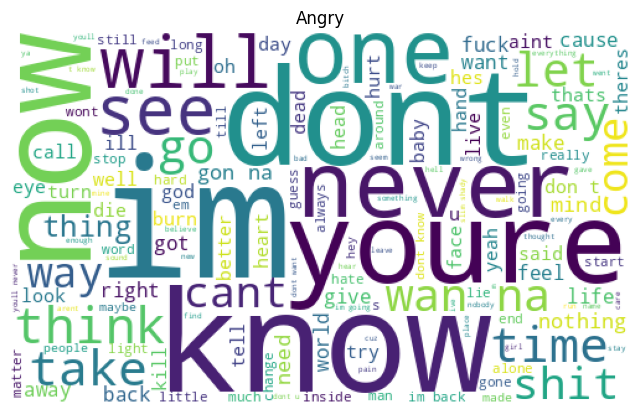

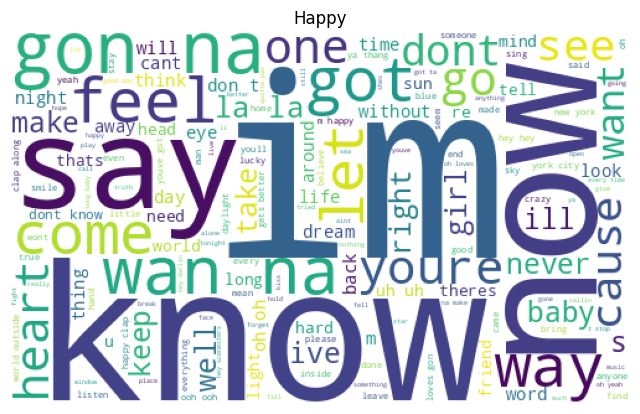

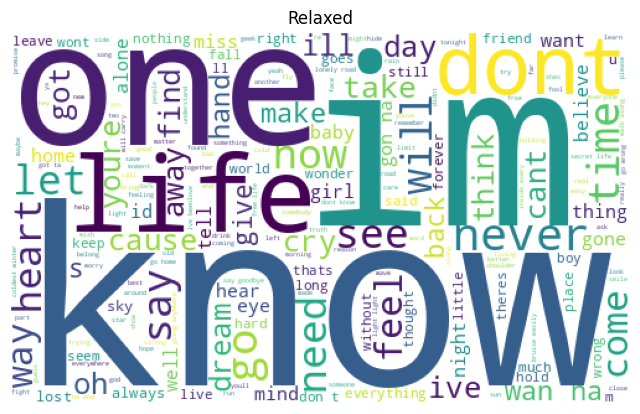

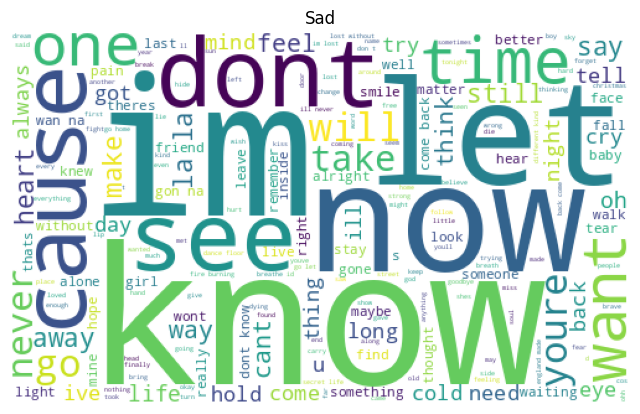

In [ ]:
# Generate word clouds for each mood category.

word_dict = dict()
for val in unique_labels:
    sentences = ""
    for l in single_label.loc[single_label['mood'] == val]['text_clean']:
        sentences += " " + l
    word_dict[val] =sentences
for key in word_dict:
    word_cloud = WordCloud(width = 500, height = 300,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 5).generate(word_dict[key])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.axis("off")
    plt.title(str(key))
    plt.imshow(word_cloud)
    plt.savefig(str(key) + ".png")

In [ ]:
#Set X_train and y_train values
X_train = single_label['text']
y_train = single_label['mood']

In [ ]:
## POSTagging class tokenizes a document using WordPunctTokenizer and returns a list of words with their corresponding POS tags.

class POSTogging:
    def __init__(self):
        self.wpt = WordPunctTokenizer()
    def __call__(self, doc):
        text = self.wpt.tokenize(doc)
        return [word + '/' + tag for word, tag in nltk.pos_tag(text)]

In [ ]:
# Define a dictionary 'n_gram_pipeline' with different n-gram configurations.

n_gram_pipeline = dict()
n_gram_pipeline['Unigram'] = (1, 1)
n_gram_pipeline['Bigram'] = (2, 2)
n_gram_pipeline['Trigram'] = (3, 3)
n_gram_pipeline['Unigram + Bigram'] = (1, 2)
n_gram_pipeline['Bigram + Trigram'] = (1, 1)
n_gram_pipeline['Unigram + Bigram  + Trigram'] = (1, 3)

In [ ]:
# Create TF-IDF vectorizers for word tokens and word tokens + POS tags, using specified n-gram features and settings.

n_gram_tfidf_features_pipeline = dict()
for features in n_gram_pipeline.keys():
        n_gram_tfidf_features_pipeline[features] = TfidfVectorizer(min_df=3, max_features=3000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=n_gram_pipeline[features],
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")
        n_gram_tfidf_features_pipeline[str(features) + " + POS"] = TfidfVectorizer(min_df=3, max_features=3000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=n_gram_pipeline[features],
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english", tokenizer=POSTogging())

In [ ]:
#Required models

models_pipeline = dict()
models_pipeline['Linear SVC'] = LinearSVC(random_state=0, tol=1e-5)
models_pipeline['Logistic Regression'] = LogisticRegression(solver='lbfgs', multi_class='auto')
models_pipeline['Decision Tree'] = DecisionTreeClassifier(max_depth=5)
models_pipeline['Random Forest'] = RandomForestClassifier(max_depth=5, n_estimators=10)
models_pipeline['MLP (ANN)'] = MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500)

In [ ]:
#clean test data

test_df.loc[:,'text_clean'] = text_cleansing(test_df.loc[:,'text'])
test_df

<ipython-input-22-fb04c0292751>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace("[\(\[].*?[\)\]]", '')
<ipython-input-22-fb04c0292751>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.str.replace('[{}]'.format(string.punctuation), '')


,mood,text,text_clean
0,Angry,[00:02.28]Screaming For Vengeance-Judas Priest...,screaming for vengeancejudas priest hey liste...
1,Angry,[00:55.00]New blood joins this earth\n[00:57.0...,new blood joins this earth and quikly hes subd...
2,Angry,[00:10.95]what are you becoming\n[00:20.77]wha...,what are you becoming what have you become onc...
3,Angry,[00:04.41]Mic check one-two\n[00:06.99]Who wou...,mic check onetwo who woulda knew whoda known f...
4,Angry,[01:06.00]I'm a cold heartbreaker\n[01:08.50]F...,im a cold heartbreaker fit ta burn and ill rip...
...,...,...,...
372,Sad,[00:01.23]I'm gonna die in these four walls\n[...,im gonna die in these four walls ive had enoug...
373,Sad,[00:17.25]You call me on the phone\n[00:20.50]...,you call me on the phone i act like nothings g...
374,Sad,[00:16.00]She's getting out of bed at half pas...,shes getting out of bed at half past ten she s...
375,Sad,[00:34.94]look on down from the bridge\n[00:40...,look on down from the bridge theres still foun...


In [ ]:
test_df.drop(['text'],axis=1)

,mood,text_clean
0,Angry,screaming for vengeancejudas priest hey liste...
1,Angry,new blood joins this earth and quikly hes subd...
2,Angry,what are you becoming what have you become onc...
3,Angry,mic check onetwo who woulda knew whoda known f...
4,Angry,im a cold heartbreaker fit ta burn and ill rip...
...,...,...
372,Sad,im gonna die in these four walls ive had enoug...
373,Sad,you call me on the phone i act like nothings g...
374,Sad,shes getting out of bed at half past ten she s...
375,Sad,look on down from the bridge theres still foun...


In [ ]:
#Set X_test and y_test values

X_test = test_df['text_clean']
y_test = test_df['mood']

In [ ]:
# Evaluate multiple models with different feature sets, record and compare their accuracies, and write results to a text file.

print("Model : Features : Model Accuracy : 5-fold cross-validation mean accuracy")
best_model_y_pred = list()
best_accuracy = 0
worst_accuracy = 1
text_file = open("model_results.txt","w+")
for models in models_pipeline.keys():
    best_accuracy = 0
    worst_accuracy = 1
    for tfv in n_gram_tfidf_features_pipeline.keys():
        pipeline = make_pipeline(n_gram_tfidf_features_pipeline[tfv], models_pipeline[models])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        tf_idf_vectorizer = n_gram_tfidf_features_pipeline[tfv]
        X_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
        scores = cross_val_score(models_pipeline[models], X_tf_idf, y_train, cv=5)
        k_fold_mean_accuracy = ("%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        test_accuracy = accuracy_score(y_pred, y_test)
        test_accuracy = ("%0.2f" % (test_accuracy))
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            btvf = tfv
            bkfold = k_fold_mean_accuracy
            best_model_y_pred = y_pred
        if test_accuracy < worst_accuracy:
            worst_accuracy = test_accuracy
            wtvf = tfv
            wkfold = k_fold_mean_accuracy
    best = str(models) + " :" + str(btvf) + " :" + str(best_accuracy) + " :" + str(bkfold)
    worst = str(models) + " :" + str(wtvf) + " :" + str(worst_accuracy) + " :" + str(wkfold)
    text_file.write(best + "\n")
    print('Best:', best)
    print('Worst:', worst)
text_file.close()

B/W: Model : Features : Model Accuracy : 5-fold cross-validation mean accuracy
Best: Linear SVC :Unigram + Bigram :0.68 (+/- 0.05)
Worst: Linear SVC :Bigram :0.5 (+/- 0.05)
Best: Logistic Regression :Unigram + Trigram :0.74 (+/- 0.06)
Worst: Logistic Regression :Trigram :0.48 (+/- 0.06)
Best: Decision Tree :Unigram + Bigram :0.62 (+/- 0.08)
Worst: Decision Tree :Unigram + Bigram + POS :0.47 (+/- 0.08)
Best: Random Forest :Unigram :0.62 (+/- 0.07)
Worst: Random Forest :Unigram + Bigram + POS :0.39 (+/- 0.07)
Best: MLP (ANN) :Unigram +  Bigram :0.61 (+/- 0.09)
Worst: MLP (ANN) :Trigram + POS :0.38 (+/- 0.09)
